![ML Logo](http://spark-mooc.github.io/web-assets/images/CS190.1x_Banner_300.png)
# **Linear Regression Lab**
This lab covers a common supervised learning pipeline, using a subset of the [Million Song Dataset](http://labrosa.ee.columbia.edu/millionsong/) from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/YearPredictionMSD). Our goal is to train a linear regression model to predict the release year of a song given a set of audio features.

The first part is based on building the linear model using Sklearn with a single process. The second part is essentially from the online course [BerkeleyX: CS190.1x Scalable Machine Learning](https://courses.edx.org/courses/BerkeleyX/CS190.1x/1T2015/info), in which we will use Spark and MLlib with two processes on a virtual machine.

###  This lab will cover: 
+   *Part 1: Using Sklearn on a single process*
 +  *Sec. 1.1:* Separating training, validation and test datasets
 +  *Sec. 1.2:* Linear Regression model training
 +  *Sec. 1.3:* Grid Search 
 +  *Sec. 1.4:* Polynomial regression
+   *Part 2: Using Spark and MLlib*
 +  *Sec. 2.1:* Read and parse the initial dataset
 +  *Sec. 2.2:* Baseline model
 +  *Sec. 2.3:* Train (via gradient descent) and evaluate a linear regression model
 +  *Sec. 2.4:* Train using MLlib and tune hyperparameters via grid search
 +  *Sec. 2.5:* Add interactions between features 

By comparison, we can conclude that the second-order polynomial linear model (with $\scriptsize x^2_1, x_1x_2, \cdots $ etc) has better prediciton performance than the linear model only with linear predictors ($\scriptsize x_1, x_2, \cdots $).

Note that, for reference, you can look up the details of the relevant Spark methods in [Spark's Python API](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD) and the relevant NumPy methods in the [NumPy Reference](http://docs.scipy.org/doc/numpy/reference/index.html).

In [1]:
labVersion = 'cs190_week3_v_1_3'

## The data

In [1]:
import numpy as np
import pandas as pd

data = pd.read_csv('millionsong.txt', header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,2001,0.884124,0.610454,0.600498,0.474669,0.247233,0.357306,0.344136,0.339641,0.600859,0.425705,0.604915,0.419193
1,2001,0.854412,0.604125,0.593634,0.495885,0.266308,0.261472,0.506387,0.464454,0.665799,0.542969,0.580444,0.445219
2,2001,0.908983,0.632063,0.557429,0.498264,0.276396,0.312810,0.448530,0.448674,0.649791,0.489869,0.591908,0.450002
3,2001,0.842525,0.561827,0.508715,0.443531,0.296734,0.250214,0.488541,0.360509,0.575435,0.361006,0.678379,0.409037
4,2001,0.909303,0.653608,0.585581,0.473251,0.251417,0.326977,0.404323,0.371155,0.629402,0.482243,0.566901,0.463374


In [2]:
data.shape

(6724, 13)

# **Part 1: Using sklearn on a single process**

In [3]:
X = data.iloc[:,1:]
y = data.iloc[:,0]
X.head(3)

,1,2,3,4,5,6,7,8,9,10,11,12
0,0.884124,0.610454,0.600498,0.474669,0.247233,0.357306,0.344136,0.339641,0.600859,0.425705,0.604915,0.419193
1,0.854412,0.604125,0.593634,0.495885,0.266308,0.261472,0.506387,0.464454,0.665799,0.542969,0.580444,0.445219
2,0.908983,0.632063,0.557429,0.498264,0.276396,0.312810,0.448530,0.448674,0.649791,0.489869,0.591908,0.450002


In [4]:
y.head(3)

0    2001
1    2001
2    2001
Name: 0, dtype: float64

## Sec. 1.1: Separating training, validation and test datasets

In [5]:
from sklearn.cross_validation import train_test_split
from sklearn import metrics, cross_validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
X_train.shape

(4034, 12)

In [6]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)
X_test.shape

(1345, 12)

In [7]:
X_val.shape

(1345, 12)

## Sec. 1.2: Linear Regression model training

For simple linear regression, refer to [linear regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) in sklearn.

In [9]:
from sklearn import linear_model
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [10]:
## compute R^2 
print (lr.score(X_val, y_val), lr.score(X_test, y_test))

0.497287299731 0.476532563406


In [11]:
def R_squared(predict, true):
    if len(predict) != len(true): return False
    meanTrue = np.mean(true)
    RSS =0
    TSS =0 
    for i in range(len(predict)):
        RSS += (predict[i] - true[i])**2
        TSS += (true[i] - meanTrue)**2
    return np.sqrt(RSS/len(predict)), 1.0-RSS/TSS

In [12]:
predictedY = lr.predict(X_val)
print (R_squared(predictedY, y_val.tolist()))

(15.460592450650008, 0.49728729973086772)


## Sec. 1.3: Grid Search 

### ** (1.3a) Ridge regression (L2)**

Refer to the [ridge regression](http://scikit-learn.org/stable/modules/linear_model.html#ridge-regression) in sklearn.

In [18]:
for lambda_i in [1e-10, 1e-5, 1e-2, 0.1, 1.0, 2.0]:
    ridge = linear_model.Ridge(alpha=lambda_i)
    ridge.fit(X_train, y_train)
    predictedY = ridge.predict(X_val)
    print (lambda_i, R_squared(predictedY, y_val.tolist()))

1e-10 (15.460592450648022, 0.49728729973099683)
1e-05 (15.460592253779264, 0.49728731253366598)
0.01 (15.46039861739483, 0.49729990491771214)
0.1 (15.458913261095528, 0.49739649400345864)
1.0 (15.460306405272094, 0.49730590151660636)
2.0 (15.477467888958312, 0.49618926586040824)


### (1.3b) LASSO (L1)

Refer to [LASSO regression](http://scikit-learn.org/stable/modules/linear_model.html#lasso) in sklearn library.

In [14]:
for lambda_i in [1e-10, 1e-5, 1e-2, 0.1, 1.0, 2.0]:
    ridge = linear_model.Lasso(alpha=lambda_i)
    ridge.fit(X_train, y_train)
    predictedY = ridge.predict(X_val)
    print (lambda_i, R_squared(predictedY, y_val.tolist()))

1e-10 (15.460592450563135, 0.4972872997365172)
1e-05 (15.460583748958394, 0.49728786561470062)
0.01 (15.46533750850878, 0.49697867418342156)
0.1 (15.778979237144268, 0.47636893652433288)
1.0 (20.476642483045577, 0.11816955565414855)
2.0 (21.807425432970533, -0.00017589907371395874)


## Sec. 1.4: Polynomial regression

Up to order of 2, i.e. square terms. Refer [the polynomial regression](http://scikit-learn.org/stable/modules/linear_model.html#polynomial-regression-extending-linear-models-with-basis-functions).

In [15]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
polyreg = Pipeline([('poly', PolynomialFeatures(degree=2)),('linear', LinearRegression(fit_intercept=True))])

In [16]:
polyreg.fit(X_train, y_train)

Pipeline(steps=[('poly', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('linear', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [17]:
predictedY = polyreg.predict(X_val)
print (R_squared(predictedY, y_val.tolist()))

(14.420119802441674, 0.56267396763799549)


In [19]:
predictedY = polyreg.predict(X_test)
print (R_squared(predictedY, y_test.tolist()))

(14.840052019616181, 0.51858814381806306)


Here, we can see that considering the order up to second-order polynomials, the mean squared erros descreases and the R-square increases on both validation and test sets. Hence the better model is for second-order polynomial on linear model.

# **Part 2: Using Spark and MLlib**

## ** Sec. 2.1: Read and parse the initial dataset **

### ** (2.1a) Load and check the data **
The raw data is currently stored in text file.  We will start by storing this raw data in as an RDD, with each element of the RDD representing a data point as a comma-delimited string. Each string starts with the label (a year) followed by numerical audio features. Use the [count method](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.count) to check how many data points we have.  Then use the [take method](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.take) to create and print out a list of the first 5 data points in their initial string format.

In [2]:
# load testing library
from test_helper import Test
import os.path
baseDir = os.path.join('data')
inputPath = os.path.join('cs190', 'millionsong.txt')
fileName = os.path.join(baseDir, inputPath)

numPartitions = 2
rawData = sc.textFile(fileName, numPartitions)

In [7]:
print type(rawData)

<class 'pyspark.rdd.RDD'>


The number of observation in the dataset is

In [89]:
numPoints = rawData.count()
print numPoints

6724


The primitive data format (reading from the text file) looks like

In [91]:
samplePoints = rawData.take(2)
print samplePoints

[u'2001.0,0.884123733793,0.610454259079,0.600498416968,0.474669212493,0.247232680947,0.357306088914,0.344136412234,0.339641227335,0.600858840135,0.425704689024,0.60491501652,0.419193351817', u'2001.0,0.854411946129,0.604124786151,0.593634078776,0.495885413963,0.266307830936,0.261472105188,0.506387076327,0.464453565511,0.665798573683,0.542968988766,0.58044428577,0.445219373624']


### ** (2.1b) Using `LabeledPoint` **
In MLlib, labeled training instances are stored using the [LabeledPoint](https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.regression.LabeledPoint) object.  Write the parsePoint function that takes as input a raw data point, parses it using Python's [unicode.split](https://docs.python.org/2/library/string.html#string.split) method, and returns a `LabeledPoint`.  Use this function to parse samplePoints (from the previous question).  Then print out the features and label for the first training point, using the `LabeledPoint.features` and `LabeledPoint.label` attributes. Finally, calculate the number features for this dataset.
Note that `split()` can be called directly on a `unicode` or `str` object.  For example, `u'split,me'.split(',')` returns `[u'split', u'me']`.

In [5]:
from pyspark.mllib.regression import LabeledPoint
import numpy as np
# Here is a sample raw data point:
# '2001.0,0.884,0.610,0.600,0.474,0.247,0.357,0.344,0.33,0.600,0.425,0.60,0.419'
# In this raw data point, 2001.0 is the label, and the remaining values are features

In [6]:
def parsePoint(line):
    """Converts a comma separated unicode string into a `LabeledPoint`.
    Args:
        line (unicode): Comma separated unicode string where the first element is the label and the
            remaining elements are features.
    Returns:
        LabeledPoint: The line is converted into a `LabeledPoint`, which consists of a label and
            features.
    """
    parsedLine = line.split(',')
    return LabeledPoint(parsedLine[0], parsedLine[1:])

Now convert all raw data to LabeledPoint class:

In [92]:
parsedSamplePoints = rawData.map(lambda x: parsePoint(x))
print type(rawData), type(parsedSamplePoints)
print parsedSamplePoints.first()
print type(parsedSamplePoints.first())

<class 'pyspark.rdd.RDD'> <class 'pyspark.rdd.PipelinedRDD'>
(2001.0,[0.884123733793,0.610454259079,0.600498416968,0.474669212493,0.247232680947,0.357306088914,0.344136412234,0.339641227335,0.600858840135,0.425704689024,0.60491501652,0.419193351817])
<class 'pyspark.mllib.regression.LabeledPoint'>


"rawData" is the RDD class, and "parsedSamplePoints" is the pipelinedRDD. Each item of the "parsedSamplePoints" is the "pyspark.mllib.regression.LabeledPoint" class. 

In [10]:
firstPointFeatures = parsedSamplePoints.first().features
firstPointLabel = parsedSamplePoints.first().label
print firstPointFeatures, firstPointLabel

<class 'pyspark.mllib.regression.LabeledPoint'>
[0.884123733793,0.610454259079,0.600498416968,0.474669212493,0.247232680947,0.357306088914,0.344136412234,0.339641227335,0.600858840135,0.425704689024,0.60491501652,0.419193351817] 2001.0


In [94]:
d = len(firstPointFeatures)
print d

12


### **(2.1c) Class of variables in this note**

In [28]:
print type(rawData)

<class 'pyspark.rdd.RDD'>


Remember we did: "parsedSamplePoints = rawData.map(lambda x: parsePoint(x))" with mapping function on rawData:

In [29]:
print type(parsedSamplePoints)

<class 'pyspark.rdd.PipelinedRDD'>


In [35]:
print type(parsedSamplePoints.take(1))
print parsedSamplePoints.take(1)

<type 'list'>
[LabeledPoint(2001.0, [0.884123733793,0.610454259079,0.600498416968,0.474669212493,0.247232680947,0.357306088914,0.344136412234,0.339641227335,0.600858840135,0.425704689024,0.60491501652,0.419193351817])]


Remember each item in the "parsedSamplePoints" is the "pyspark.mllib.regression.LabeledPoint" class:

In [36]:
print type(parsedSamplePoints.take(1)[0])
print parsedSamplePoints.take(1)[0]

<class 'pyspark.mllib.regression.LabeledPoint'>
(2001.0,[0.884123733793,0.610454259079,0.600498416968,0.474669212493,0.247232680947,0.357306088914,0.344136412234,0.339641227335,0.600858840135,0.425704689024,0.60491501652,0.419193351817])


In [37]:
print type(parsedSamplePoints.take(1)[0].features), type(parsedSamplePoints.take(1)[0].label)
print parsedSamplePoints.take(1)[0].features, parsedSamplePoints.take(1)[0].label

<class 'pyspark.mllib.linalg.DenseVector'> <type 'float'>
[0.884123733793,0.610454259079,0.600498416968,0.474669212493,0.247232680947,0.357306088914,0.344136412234,0.339641227335,0.600858840135,0.425704689024,0.60491501652,0.419193351817] 2001.0


The features is represented as DenseVetor class.

### **(2.1d) Find the range of y (label)**
Now let's examine the labels to find the range of song years.  To do this, first parse each element of the `rawData` RDD, and then find the smallest and largest labels. There are two ways to do it:

In [15]:
parsedDataInit = rawData.map(lambda x: parsePoint(x))

The first is that we generate "paredDataInit" as pipelinedRDD, and after the collect method, "onlyLabels" to become a list:

In [19]:
onlyLabels = parsedDataInit.map(lambda x: x.label).collect()
print type(onlyLabels)
minYear = min(onlyLabels)
maxYear = max(onlyLabels)
print maxYear, minYear

<type 'list'>
2011.0 1922.0


The second one is that we deal with "onlyLabels" as a pipelinedRDD:

In [20]:
onlyLabels = parsedDataInit.map(lambda x: x.label)
print type(onlyLabels)
minYear = onlyLabels.min()
maxYear = onlyLabels.max()
print maxYear, minYear

<class 'pyspark.rdd.PipelinedRDD'>
2011.0 1922.0


### **(2.1e) Shift labels **
As we just saw, the labels are years in the 1900s and 2000s.  In learning problems, it is often natural to shift labels such that they start from zero.  Starting with `parsedDataInit`, create a new RDD consisting of `LabeledPoint` objects in which the labels are shifted such that smallest label equals zero.

In [40]:
parsedData = parsedDataInit.map(lambda x: LabeledPoint(x.label-minYear, x.features))
# Should be a LabeledPoint
print type(parsedData)
print type(parsedData.take(1)[0])
# View the first point
print '\n{0}'.format(parsedData.take(1))
print (parsedData.take(1)[0].label)

<class 'pyspark.rdd.PipelinedRDD'>
<class 'pyspark.mllib.regression.LabeledPoint'>

[LabeledPoint(79.0, [0.884123733793,0.610454259079,0.600498416968,0.474669212493,0.247232680947,0.357306088914,0.344136412234,0.339641227335,0.600858840135,0.425704689024,0.60491501652,0.419193351817])]
79.0


After shifting, the maximum and minimum values are

In [42]:
print max(parsedData.map(lambda x: x.label).collect())
print min(parsedData.map(lambda x: x.label).collect())

89.0
0.0


### ** (2.1f) Training, validation, and test sets **
We're almost done parsing our dataset, and our final task involves split it into training, validation and test sets. Use the [randomSplit method](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.randomSplit) with the specified weights and seed to create RDDs storing each of these datasets. Next, cache each of these RDDs, as we will be accessing them multiple times in the remainder of this lab. Finally, compute the size of each dataset and verify that the sum of their sizes equals the value computed in Part (1a).

In [95]:
weights = [.8, .1, .1]
seed = 42
parsedTrainData, parsedValData, parsedTestData = parsedData.randomSplit(weights, seed)
parsedTrainData.cache()
parsedValData.cache()
parsedTestData.cache()

PythonRDD[6434] at RDD at PythonRDD.scala:43

In [96]:
nTrain = parsedTrainData.count()
nVal = parsedValData.count()
nTest = parsedTestData.count()

print nTrain, nVal, nTest, nTrain + nVal + nTest
print parsedData.count()

5371 682 671 6724
6724


## ** Sec. 2.2: Baseline model **

### **(2.2a) Average label **
A very simple yet natural baseline model is one where we always make the same prediction independent of the given data point, using the average label in the training set as the constant prediction value.  Compute this value, which is the average (shifted) song year for the training set.  Use an appropriate method in the [RDD API](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD).

In [98]:
from operator import add
averageTrainYear = parsedTrainData.map(lambda x: x.label).reduce(add)/float(nTrain)
averageValYear = parsedValData.map(lambda x: x.label).reduce(add)/float(nVal)
averageTestYear = parsedTestData.map(lambda x: x.label).reduce(add)/float(nTest)
print type(labelsAndPredsTrain)
print averageTrainYear, averageValYear, averageTestYear

<class 'pyspark.rdd.PipelinedRDD'>
53.9316700801 53.7287390029 52.6691505216


### **(2.2b) Defining root mean squared error **
We naturally would like to see how well this naive baseline performs.  We will use root mean squared error ([RMSE](http://en.wikipedia.org/wiki/Root-mean-square_deviation)) for evaluation purposes.  Implement a function to compute RMSE given an RDD of (label, prediction) tuples, and test out this function on an example.

In [45]:
def squaredError(label, prediction):
    """Calculates the the squared error for a single prediction.

    Args:
        label (float): The correct value for this observation.
        prediction (float): The predicted value for this observation.

    Returns:
        float: The difference between the `label` and `prediction` squared.
    """
    return (float(label) - float(prediction))**2

def calcRMSE(labelsAndPreds):
    """Calculates the root mean squared error for an `RDD` of (label, prediction) tuples.

    Args:
        labelsAndPred (RDD of (float, float)): An `RDD` consisting of (label, prediction) tuples.

    Returns:
        float: The square root of the mean of the squared errors.
    """
    diff = labelsAndPreds.map(lambda x: squaredError(x[0],x[1]))
    return np.sqrt(diff.sum()/float(diff.count()))

In [99]:
labelsAndPreds = sc.parallelize([(3., 1.), (1., 2.), (2., 2.)])
# RMSE = sqrt[((3-1)^2 + (1-2)^2 + (2-2)^2) / 3] = 1.291
exampleRMSE = calcRMSE(labelsAndPreds)
print exampleRMSE

1.29099444874


### **(2.2c) Training, validation and test RMSE **
Now let's calculate the training, validation and test RMSE of our baseline model. To do this, first create RDDs of (label, prediction) tuples for each dataset, and then call calcRMSE. Note that each RMSE can be interpreted as the average prediction error [we did in (2.2a)] for the given dataset (in terms of number of years).

In [100]:
print averageTrainYear, averageValYear, averageTestYear

53.9316700801 53.7287390029 52.6691505216


In [52]:
labelsAndPredsTrain = parsedTrainData.map(lambda x: (x.label, averageTrainYear))
rmseTrainBase = calcRMSE(labelsAndPredsTrain)
# --------------------------
labelsAndPredsVal = parsedValData.map(lambda x: (x.label, averageValYear))
rmseValBase = calcRMSE(labelsAndPredsVal)
# ---------------------------
labelsAndPredsTest = parsedTestData.map(lambda x: (x.label, averageTestYear))
rmseTestBase = calcRMSE(labelsAndPredsTest)

print 'Baseline Train RMSE = {0:.3f}'.format(rmseTrainBase)
print 'Baseline Validation RMSE = {0:.3f}'.format(rmseValBase)
print 'Baseline Test RMSE = {0:.3f}'.format(rmseTestBase)

Baseline Train RMSE = 21.306
Baseline Validation RMSE = 21.585
Baseline Test RMSE = 22.101


## ** Sec. 2.3: Train (via gradient descent) and evaluate a linear regression model **

### ** (2.3a) Gradient summand **
Now let's see if we can do better via linear regression, training a model via gradient descent (we'll omit the intercept for now). Recall that the gradient descent update for linear regression is: 
$$ \scriptsize \mathbf{w}_{i+1} = \mathbf{w}_i - \alpha_i \sum_j (\mathbf{w}_i^\top\mathbf{x}_j  - y_j) \mathbf{x}_j \,.$$ 
where $ \scriptsize i $ is the iteration number of the gradient descent algorithm, and $ \scriptsize j $ identifies the observation.

First, implement a function that computes the summand for this update, i.e., the summand equals $ \scriptsize (\mathbf{w}^\top \mathbf{x} - y) \mathbf{x} \, ,$ and test out this function on two examples.  Use the `DenseVector` [dot](http://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.linalg.DenseVector.dot) method.

In [55]:
from pyspark.mllib.linalg import DenseVector

In [56]:
def gradientSummand(weights, lp):
    """Calculates the gradient summand for a given weight and `LabeledPoint`.
    Note:
        `DenseVector` behaves similarly to a `numpy.ndarray` and they can be used interchangably
        within this function.  For example, they both implement the `dot` method.

    Args:
        weights (DenseVector): An array of model weights (betas).
        lp (LabeledPoint): The `LabeledPoint` for a single observation.

    Returns:
        DenseVector: An array of values the same length as `weights`.  The gradient summand.
    """
    return (weights.dot(lp.features)-lp.label) * lp.features

In [103]:
#exampleW = DenseVector([1, 1, 1])
exampleW = np.array([1, 1, 1])
exampleLP = LabeledPoint(2.0, [3, 1, 4])
# gradientSummand = (dot([1 1 1], [3 1 4]) - 2) * [3 1 4] = (8 - 2) * [3 1 4] = [18 6 24]
summandOne = gradientSummand(exampleW, exampleLP)
print summandOne

[18.0,6.0,24.0]


### ** (2.3b) Use weights to make predictions **
Next, implement a `getLabeledPredictions` function that takes in weights and an observation's `LabeledPoint` and returns a (label, prediction) tuple.  Note that we can predict by computing the dot product between weights and an observation's features.

In [62]:
def getLabeledPrediction(weights, observation):
    """Calculates predictions and returns a (label, prediction) tuple.

    Note:
        The labels should remain unchanged as we'll use this information to calculate prediction
        error later.

    Args:
        weights (np.ndarray): An array with one weight for each features in `trainData`.
        observation (LabeledPoint): A `LabeledPoint` that contain the correct label and the
            features for the data point.

    Returns:
        tuple: A (label, prediction) tuple.
    """
    return (observation.label, DenseVector.dot(DenseVector(weights), observation.features))

Generate toy dataset to test the function:

In [63]:
weights = np.array([1.0, 1.5])
predictionExample = sc.parallelize([LabeledPoint(2, np.array([1.0, .5])),
                                    LabeledPoint(1.5, np.array([.5, .5]))])
# w = (1, 1.5)
# y1 = 2  , x1 = (1, 0.5)
# y2 = 1.5, x2 = (0.5, 0.5)
# prediction_1 = w * x1 = (1, 1.5) * (1, 0.5) = 1+ 0.75 = 1.75
# prediction_2 = w * x2 = (1, 1.5) * (0.5, 0.5) = 0.5 +0.75 = 1.25
print predictionExample.take(2)
labelsAndPredsExample = predictionExample.map(lambda lp: getLabeledPrediction(weights, lp))
print labelsAndPredsExample.collect()

[LabeledPoint(2.0, [1.0,0.5]), LabeledPoint(1.5, [0.5,0.5])]
[(2.0, 1.75), (1.5, 1.25)]


### ** (2.3c) Gradient descent **
Next, implement a gradient descent function for linear regression and test out this function on an example.

In [65]:
def linregGradientDescent(trainData, numIters):
    """Calculates the weights and error for a linear regression model trained with gradient descent.
    Note:
        `DenseVector` behaves similarly to a `numpy.ndarray` and they can be used interchangably
        within this function.  For example, they both implement the `dot` method.
    Args:
        trainData (RDD of LabeledPoint): The labeled data for use in training the model.
        numIters (int): The number of iterations of gradient descent to perform.

    Returns:
        (np.ndarray, np.ndarray): A tuple of (weights, training errors).  Weights will be the
            final weights (one weight per feature) for the model, and training errors will contain
            an error (RMSE) for each iteration of the algorithm.
    """
    # The length of the training data
    n = trainData.count()
    # The number of features in the training data
    d = len(trainData.take(1)[0].features)
    w = np.zeros(d)
    alpha = 1.0
    # We will compute and store the training error after each iteration
    errorTrain = np.zeros(numIters)
    for i in range(numIters):
        # Use getLabeledPrediction from (3b) with trainData to obtain an RDD of (label, prediction)
        # tuples.  Note that the weights all equal 0 for the first iteration, so the predictions will
        # have large errors to start.
        labelsAndPredsTrain = trainData.map(lambda lp: getLabeledPrediction(w, lp))
        errorTrain[i] = calcRMSE(labelsAndPredsTrain)

        # Calculate the `gradient`.  Make use of the `gradientSummand` function you wrote in (3a).
        # Note that `gradient` sould be a `DenseVector` of length `d`.
        gradient = trainData.map(lambda lp: gradientSummand(w, lp)).reduce(add)
        ''' or gradient = trainData.map(lambda lp: gradientSummand(w, lp)).sum() '''
        
        print i, 'RMSE= ', errorTrain[i]
        # Update the weights
        alpha_i = alpha / (n * np.sqrt(i+1))
        w -= alpha_i* gradient
    return w, errorTrain

In the followings, we create a toy dataset with n = 10 (10 observations), d = 3 (3 features), and then run 5 iterations of gradient descent. Note that the resulting model will not be useful; it is a toy test. The goal here is to check that linregGradientDescent is working properly:

In [68]:
exampleN = 10
exampleD = 3
exampleData = (sc.parallelize(parsedTrainData.take(exampleN))
               .map(lambda lp: LabeledPoint(lp.label, lp.features[0:exampleD])))
print exampleData.take(2)

[LabeledPoint(79.0, [0.884123733793,0.610454259079,0.600498416968]), LabeledPoint(79.0, [0.854411946129,0.604124786151,0.593634078776])]


The resulting "exampleWeights" is 3-dimensional and is a "np.array" class:

In [70]:
exampleNumIters = 5
exampleWeights, exampleErrorTrain = linregGradientDescent(exampleData, exampleNumIters)
print type(exampleWeights), exampleWeights

0 RMSE=  79.720135474
1 RMSE=  30.278356987
2 RMSE=  9.27842641274
3 RMSE=  9.20967856405
4 RMSE=  9.19446482628
<type 'numpy.ndarray'> [ 48.88110449  36.01144093  30.25350092]


### ** (2.3d) Train the model **
Now let's seriously train a linear regression model on all of our training data and evaluate its accuracy on the validation set.  Note that the test set will not be used here.  If we evaluated the model on the test set, we would bias our final results.

We've already done much of the required work: we computed the number of features in Part (2.1b); we created the training and validation datasets and computed their sizes in Part (2.1e); and, we wrote a function to compute RMSE in Part (2.2b).

In [72]:
numIters = 50
weightsLR0, errorTrainLR0 = linregGradientDescent(parsedTrainData,numIters)

0 RMSE=  57.9876286089
1 RMSE=  105.634724083
2 RMSE=  111.85702947
3 RMSE=  77.8405077938
4 RMSE=  39.91899243
5 RMSE=  22.7317937659
6 RMSE=  20.2054568839
7 RMSE=  20.0339150616
8 RMSE=  19.9644474223
9 RMSE=  19.9011299208
10 RMSE=  19.842131161
11 RMSE=  19.7868293254
12 RMSE=  19.7347370379
13 RMSE=  19.6854635199
14 RMSE=  19.6386898421
15 RMSE=  19.5941517638
16 RMSE=  19.5516274995
17 RMSE=  19.5109287878
18 RMSE=  19.4718942357
19 RMSE=  19.4343842674
20 RMSE=  19.39827723
21 RMSE=  19.3634663481
22 RMSE=  19.3298573112
23 RMSE=  19.2973663411
24 RMSE=  19.2659186269
25 RMSE=  19.2354470469
26 RMSE=  19.2058911138
27 RMSE=  19.1771960996
28 RMSE=  19.1493123023
29 RMSE=  19.1221944284
30 RMSE=  19.0958010694
31 RMSE=  19.0700942551
32 RMSE=  19.0450390708
33 RMSE=  19.0206033275
34 RMSE=  18.9967572759
35 RMSE=  18.9734733585
36 RMSE=  18.9507259921
37 RMSE=  18.9284913779
38 RMSE=  18.9067473341
39 RMSE=  18.885473148
40 RMSE=  18.8646494452
41 RMSE=  18.844258073
42 RMSE=  

Now the training via gradient descent is done and we have a model:

In [75]:
print weightsLR0

[ 22.64535883  20.064699    -0.05341901   8.2931319    5.79155768
  -4.51008084  15.23075467   3.8465554    9.91992022   5.97465933
  11.36849033   3.86452361]


and calculate RMSE:

In [74]:
labelsAndPreds = parsedValData.map(lambda lp: getLabeledPrediction(weightsLR0, lp))
print labelsAndPreds.take(2)
rmseValLR0 = calcRMSE(labelsAndPreds)

print 'Validation RMSE:\n\tBaseline = {0:.3f}\n\tLR0 = {1:.3f}'.format(rmseValBase,
                                                                       rmseValLR0)

[(79.0, 64.012682471741243), (86.0, 48.282734919171631)]
Validation RMSE:
	Baseline = 21.585
	LR0 = 19.192


### ** (2.3e) Training error visualization **
We will look at the log of the training error as a function of iteration. The plot shows the training error itself, focusing on the final 44 iterations.

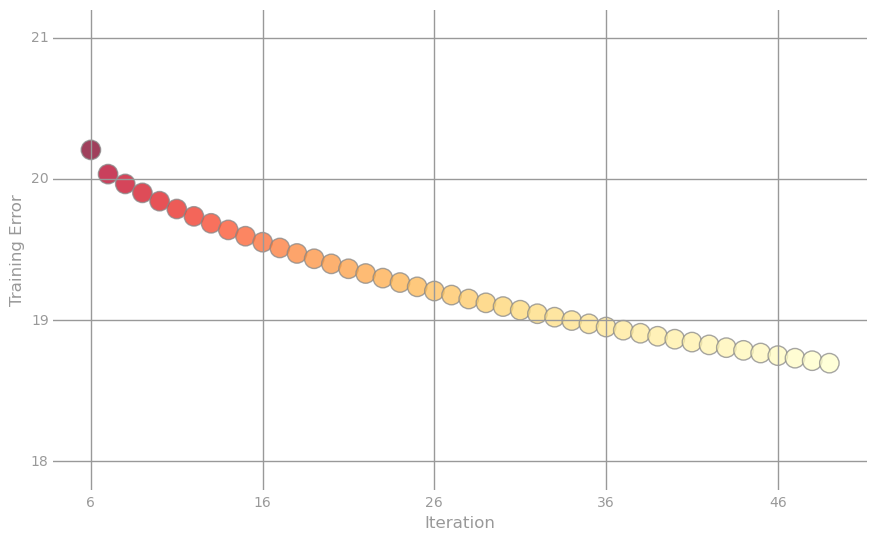

In [379]:
norm = Normalize()
clrs = cmap(np.asarray(norm(errorTrainLR0[6:])))[:,0:3]

fig, ax = preparePlot(np.arange(0, 60, 10), np.arange(17, 22, 1))
ax.set_ylim(17.8, 21.2)
plt.scatter(range(0, numIters-6), errorTrainLR0[6:], s=14**2, c=clrs, edgecolors='#888888', alpha=0.75)
ax.set_xticklabels(map(str, range(6, 66, 10)))
ax.set_xlabel('Iteration'), ax.set_ylabel(r'Training Error')
pass

## ** Sec. 2.4: Train using MLlib and perform grid search **

### **(2.4a) `LinearRegressionWithSGD` **
We're already doing better than the baseline model, but let's see if we can do better by adding an intercept, using regularization, and (based on the previous visualization) training for more iterations.  MLlib's [LinearRegressionWithSGD](https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.regression.LinearRegressionWithSGD) essentially implements the same algorithm that we implemented in (2.3b), albeit more efficiently and with various additional functionality, such as stochastic gradient approximation, including an intercept in the model and also allowing L1 or L2 regularization.  First use LinearRegressionWithSGD to train a model with L2 regularization and with an intercept.  This method returns a [LinearRegressionModel](https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.regression.LinearRegressionModel).  Next, use the model's [weights](http://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.regression.LinearRegressionModel.weights) and [intercept](http://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.regression.LinearRegressionModel.intercept) attributes to print out the model's parameters.

In [78]:
from pyspark.mllib.regression import LinearRegressionWithSGD
# Values to use when training the linear regression model
numIters = 500  # iterations
alpha = 1.0  # step
miniBatchFrac = 1.0  # miniBatchFraction
reg = 1e-1  # regParam
regType = 'l2'  # regType
useIntercept = True  # intercept

In [79]:
firstModel = LinearRegressionWithSGD.train(parsedTrainData, step=alpha, \
                                           miniBatchFraction=miniBatchFrac, iterations=numIters,\
                                           regParam=reg, regType=regType, intercept=useIntercept)

# weightsLR1 stores the model weights; interceptLR1 stores the model intercept
weightsLR1 = firstModel.weights
interceptLR1 = firstModel.intercept
print weightsLR1, interceptLR1

[16.682292427,14.7439059559,-0.0935105608897,6.22080088829,4.01454261926,-3.30214858535,11.0403027232,2.67190962854,7.18925791279,4.46093254586,8.14950409475,2.75135810882] 13.3335907631


### **(2.4b) Predict**
Now use the [LinearRegressionModel.predict()](http://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.regression.LinearRegressionModel.predict) method to make a prediction on a sample point.  Pass the `features` from a `LabeledPoint` into the `predict()` method.

In [81]:
samplePoint = parsedTrainData.take(1)[0]
print samplePoint
samplePrediction = firstModel.predict(samplePoint.features)
print samplePrediction

(79.0,[0.884123733793,0.610454259079,0.600498416968,0.474669212493,0.247232680947,0.357306088914,0.344136412234,0.339641227335,0.600858840135,0.425704689024,0.60491501652,0.419193351817])
56.8013380112


### ** (2.4c) Evaluate RMSE **
Next evaluate the accuracy of this model on the validation set.  Use the `predict()` method to create a `labelsAndPreds` RDD, and then use the `calcRMSE()` function from (2.2b).

In [83]:
labelsAndPreds = parsedValData.map(lambda lp: (lp.label, firstModel.predict(lp.features)))
rmseValLR1 = calcRMSE(labelsAndPreds)

print ('Validation RMSE:\n\tBaseline = {0:.3f}\n\tLR0 = {1:.3f}' +
       '\n\tLR1 = {2:.3f}').format(rmseValBase, rmseValLR0, rmseValLR1)

Validation RMSE:
	Baseline = 21.585
	LR0 = 19.192
	LR1 = 19.691


### ** (2.4d) Grid search **
We're already outperforming the baseline on the validation set by almost 2 years on average, but let's see if we can do better. Perform grid search to find a good regularization parameter.  Try `regParam` values `1e-10`, `1e-5`, and `1`.

In [104]:
bestRMSE = rmseValLR1
bestRegParam = reg
bestModel = firstModel

numIters = 500
alpha = 1.0
miniBatchFrac = 1.0
for reg in [1e-10, 1e-5, 1]:
    model = LinearRegressionWithSGD.train(parsedTrainData, numIters, alpha,
                                          miniBatchFrac, regParam=reg,
                                          regType='l2', intercept=True)
    labelsAndPreds = parsedValData.map(lambda lp: (lp.label, model.predict(lp.features)))
    rmseValGrid = calcRMSE(labelsAndPreds)
    print reg, rmseValGrid
    if rmseValGrid < bestRMSE:
        bestRMSE = rmseValGrid
        bestRegParam = reg
        bestModel = model

1e-10 17.0171700716
1e-05 17.0175981807
1 23.8007746698


In [105]:
rmseValLRGrid = bestRMSE
print ('Validation RMSE:\n\tBaseline = {0:.3f}\n\tLR0 = {1:.3f}\n\tLR1 = {2:.3f}\n' +
       '\tLRGrid = {3:.3f}').format(rmseValBase, rmseValLR0, rmseValLR1, rmseValLRGrid)

Validation RMSE:
	Baseline = 21.585
	LR0 = 19.192
	LR1 = 19.691
	LRGrid = 17.017


### ** (2.4e) Vary alpha (learning rate) and the number of iterations **
In the previous grid search, we set `alpha = 1` for all experiments.  Now let's see what happens when we vary `alpha`.  Specifically, try `1e-5` and `10` as values for `alpha` and also try training models for 500 iterations (as before) but also for 5 iterations. Evaluate all models on the validation set.  Note that if we set `alpha` too small the gradient descent will require a huge number of steps to converge to the solution, and if we use too large of an `alpha` it can cause numerical problems, like you'll see below for `alpha = 10`.

In [87]:
reg = bestRegParam
modelRMSEs = []
for alpha in [1e-5, 10]:
    for numIters in [5,500]:
        model = LinearRegressionWithSGD.train(parsedTrainData, numIters, alpha,
                                              miniBatchFrac, regParam=reg,
                                              regType='l2', intercept=True)
        labelsAndPreds = parsedValData.map(lambda lp: (lp.label, model.predict(lp.features)))
        rmseVal = calcRMSE(labelsAndPreds)
        print 'alpha = {0:.0e}, numIters = {1}, RMSE = {2:.3f}'.format(alpha, numIters, rmseVal)
        modelRMSEs.append(rmseVal)

alpha = 1e-05, numIters = 5, RMSE = 56.970
alpha = 1e-05, numIters = 500, RMSE = 56.893
alpha = 1e+01, numIters = 5, RMSE = 355124752.221
alpha = 1e+01, numIters = 500, RMSE = 33110728225678989137251839534941311488306376280786874812632607716020409015644103457295574688229365257796099669135380709376.000


## ** Sec. 2.5: Add interactions between features **

### ** (2.5a) Add 2-way interactions **
So far, we've used the features as they were provided.  Now, we will add features that capture the two-way interactions between our existing features.  Write a function `twoWayInteractions` that takes in a `LabeledPoint` and generates a new `LabeledPoint` that contains the old features and the two-way interactions between them.  Note that a dataset with three features would have nine ( $ \scriptsize 3^2 $ ) two-way interactions.

You might want to use [itertools.product](https://docs.python.org/2/library/itertools.html#itertools.product) to generate tuples for each of the possible 2-way interactions.  Remember that you can combine two `DenseVector` or `ndarray` objects using [np.hstack](http://docs.scipy.org/doc/numpy/reference/generated/numpy.hstack.html#numpy.hstack).

In [106]:
from itertools import product
def twoWayInteractions(lp):
    """Creates a new `LabeledPoint` that includes two-way interactions.

    Note:
        For features [x, y] the two-way interactions would be [x^2, x*y, y*x, y^2] and these
        would be appended to the original [x, y] feature list.

    Args:
        lp (LabeledPoint): The label and features for this observation.

    Returns:
        LabeledPoint: The new `LabeledPoint` should have the same label as `lp`.  Its features
            should include the features from `lp` followed by the two-way interaction features.
    """
    twoTerms = [x*y for x in lp.features for y in lp.features]
    return LabeledPoint(lp.label, np.hstack((lp.features, twoTerms)))

In [107]:
print twoWayInteractions(LabeledPoint(0.0, [2, 3]))

(0.0,[2.0,3.0,4.0,6.0,6.0,9.0])


In [108]:
# Transform the existing train, validation, and test sets to include two-way interactions.
trainDataInteract = parsedTrainData.map(lambda lp: twoWayInteractions(lp))
valDataInteract = parsedValData.map(lambda lp: twoWayInteractions(lp))
testDataInteract = parsedTestData.map(lambda lp: twoWayInteractions(lp))

In [111]:
print len(parsedTrainData.take(1)[0].features)

12


Now the number of features is 12+12**2:

In [112]:
print len(trainDataInteract.take(1)[0].features)

156


### ** (2.5b) Build interaction model **
Now, let's build the new model.  We've done this several times now.  To implement this for the new features, we need to change a few variable names.  Remember that we should build our model from the training data and evaluate it on the validation data.

 Note that you should re-run your hyperparameter search after changing features, as using the best hyperparameters from your prior model will not necessary lead to the best model.  For this exercise, we have already preset the hyperparameters to reasonable values.

In [520]:
numIters = 500
alpha = 1.0
miniBatchFrac = 1.0
reg = 1e-10

modelInteract = LinearRegressionWithSGD.train(trainDataInteract, numIters, alpha,
                                              miniBatchFrac, regParam=reg,
                                              regType='l2', intercept=True)
labelsAndPredsInteract = valDataInteract.map(lambda lp: (lp.label, modelInteract.predict(lp.features)))
rmseValInteract = calcRMSE(labelsAndPredsInteract)

print ('Validation RMSE:\n\tBaseline = {0:.3f}\n\tLR0 = {1:.3f}\n\tLR1 = {2:.3f}\n\tLRGrid = ' +
       '{3:.3f}\n\tLRInteract = {4:.3f}').format(rmseValBase, rmseValLR0, rmseValLR1,
                                                 rmseValLRGrid, rmseValInteract)

Validation RMSE:
	Baseline = 21.585
	LR0 = 19.192
	LR1 = 19.691
	LRGrid = 17.017
	LRInteract = 15.690


### ** (2.5c) Evaluate interaction model on test data **
Our final step is to evaluate the new model on the test dataset.  Note that we haven't used the test set to evaluate any of our models.  Because of this, our evaluation provides us with an unbiased estimate for how our model will perform on new data.  If we had changed our model based on viewing its performance on the test set, our estimate of RMSE would likely be overly optimistic.

We'll also print the RMSE for both the baseline model and our new model.  With this information, we can see how much better our model performs than the baseline model.

In [526]:
labelsAndPredsTest = testDataInteract.map(lambda lp: (lp.label, modelInteract.predict(lp.features)))
rmseTestInteract = calcRMSE(labelsAndPredsTest)
print ('Test RMSE:\n\tBaseline = {0:.3f}\n\tLRInteract = {1:.3f}'
       .format(rmseTestBase, rmseTestInteract))

Test RMSE:
	Baseline = 22.101
	LRInteract = 16.327


We can see with considering the second-order terms, the RMSE's are 15.690 and 16.327 for validation and test sets, respectively. Without the terms the RMSE's are 17.017 and 17.344 for validation and test sets. Hence, similar to the case using sklearn, the second-order polynomial linear model improves the prediciton performance.